# Evaluation and comparisons of solvers

We have three jigsaw puzzle solvers based on the following models which solve the __left-right-adjacency-problem__, namely

* AdjacencyClassifier_NoML 
* FromScratch
* ResNetFT


To avoid introducing more terms, we call the jigsaw solvers by the names of the models they are based upon. We evaulate these solvers on 80 images from the CUB-200 test data set and compare their respective performances

In [62]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_unweighted
import matplotlib.ticker as plticker
import os
import sys


import pprint
import itertools
from collections import defaultdict
import copy

# generate random integer values
import random
from random import seed
from random import randint
import numpy as np
import pandas as pd
from pylab import array
from random import sample
import math

import shelve

import torch
from torch.utils.data import Dataset, DataLoader, IterableDataset
from torchvision import transforms, utils
from torch import nn, optim
from torchvision import datasets, transforms
#from torchvision.utils import make_grid


from Puzzle_generator import *
from Checking_adjacency_dataset import *
from FromScratch_CNN import *
from ResNetFT_Finetuning import *
from Training_template import *
from Adjacency_distance import *
from Search_template_gpu import *

# Setting up

## Checking GPU availability

In [63]:
if torch.cuda.is_available():
    GpuAvailable=True
    my_device = torch.device("cuda:0")   
    print("Running on the GPU")
else:
    GpuAvailable=False
    my_device = torch.device("cpu")
    print("Running on the CPU")




Running on the CPU


## Inputs

In [64]:
#Input global variables
my_test_dir = os.getenv("MY_TEST_DIR")
no_of_test_images = 80
my_puzzle_square_piece_dim = 75


## Loading models

In [65]:
my_learning_rate = 0.001
my_momentum = 0.9


In [66]:
model_names = ['AdjacencyClassifier_NoML', 'FromScratch', 'ResNetFT']
models = [AdjacencyClassifier_NoML()]
for i in [1,2]:
    model_name=model_names[i]
    model,loss_criterion,optimizer = make_model_lc_optimizer(model_name,
                                                             my_learning_rate,
                                                             my_momentum)
    best_model_path=f"./best_model_for_{model_name}.pt"
    model, optimizer, epochs_trained, min_val_loss = load_checkpoint_gpu(best_model_path,
                                                                         model, 
                                                                         optimizer,
                                                                         GpuAvailable)
    model.eval()
    models.append(model)
    if 'GpuAvailable':
        models[i].to(my_device)

    
    
    

Using FromScratch - Expect more number of parameters to learn!
	 bigunit.0.conv1.weight
	 bigunit.0.conv2.weight
	 bigunit.0.unit.2.weight
	 bigunit.0.unit.2.bias
	 bigunit.0.unit.5.weight
	 bigunit.0.unit.5.bias
	 bigunit.1.conv1.weight
	 bigunit.1.conv2.weight
	 bigunit.1.unit.2.weight
	 bigunit.1.unit.2.bias
	 bigunit.1.unit.5.weight
	 bigunit.1.unit.5.bias
	 bigunit.2.conv1.weight
	 bigunit.2.conv2.weight
	 bigunit.2.unit.2.weight
	 bigunit.2.unit.2.bias
	 bigunit.2.unit.5.weight
	 bigunit.2.unit.5.bias
	 bigunit.3.conv1.weight
	 bigunit.3.conv2.weight
	 bigunit.3.unit.2.weight
	 bigunit.3.unit.2.bias
	 bigunit.3.unit.5.weight
	 bigunit.3.unit.5.bias
	 bigunit.4.conv1.weight
	 bigunit.4.conv2.weight
	 bigunit.4.unit.2.weight
	 bigunit.4.unit.2.bias
	 bigunit.4.unit.5.weight
	 bigunit.4.unit.5.bias
	 bigunit.5.conv1.weight
	 bigunit.5.conv2.weight
	 bigunit.5.unit.2.weight
	 bigunit.5.unit.2.bias
	 bigunit.5.unit.5.weight
	 bigunit.5.unit.5.bias
	 fc1.weight
	 fc1.bias
	 bn1.weight


## Solver evaluation functions

In [67]:
def calculate_example_metric(file_name, puzzle_square_piece_dim,model_name, model, puzzle_input,device, show_solving_progress=False,input_display=False):
    if show_solving_progress:
        print(f"Solving {file_name}...")
    rows = puzzle_input[0]
    cols = puzzle_input[1] 
    no_of_pieces = rows*cols
    top_left_piece_new_label = puzzle_input[2] 
    top_left_piece_orientation = puzzle_input[3] 
    new_to_old_label_dict = puzzle_input[4]
    shuffled_puzzle_pieces_np = puzzle_input[5]
    board = solve_puzzle(rows, cols,top_left_piece_new_label,top_left_piece_orientation, 
                         shuffled_puzzle_pieces_np, puzzle_square_piece_dim,model_name, model,device,show_solving_progress)
    if show_solving_progress:
        print("*****************")
        print(f"Solved puzzle using {model_name} solver")
        board.display(puzzle_square_piece_dim)    
    information_dict = board.information_dict
    predicted_new_to_old_dict = board.predicted_new_to_old_dict
    correct_position = 0
    correct_position_and_rotation = 0
    for k in new_to_old_label_dict:
        if new_to_old_label_dict[k][:2] == predicted_new_to_old_dict[k][:2]:
            correct_position += 1
            if new_to_old_label_dict[k][2] == predicted_new_to_old_dict[k][2]:
                correct_position_and_rotation += 1
    if show_solving_progress:
        print("*******************")
        print(f"In correct position: {correct_position}")
        print(f"In correct position and rotation: {correct_position_and_rotation}")
    return(no_of_pieces, correct_position, correct_position_and_rotation)

    


In [68]:
import time 
def run_solver(image_name,i,eval_df,count,row_number):
    my_model_name = model_names[i]
    my_model = models[i]
    start_time = time.time()
    my_input = get_puzzle_pieces(image_name,my_puzzle_square_piece_dim, display=False)
    pieces,correct_pos,correct_pos_and_rotation = calculate_example_metric(image_name,my_puzzle_square_piece_dim,
                                                                           my_model_name, my_model,my_input,my_device,
                                                                           show_solving_progress=False,
                                                                           input_display=False)
    time_taken = round(time.time()-start_time,2)
    results_dict = {"model" : my_model_name,
                    "image_name": image_name,
                    "image_index" : count,
                    "no_of_pieces": pieces,
                    "correct_pos": correct_pos, 
                    "correct_pos_and_orientation": correct_pos_and_rotation,
                    "time_taken": time_taken}
    eval_df.loc[row_number] = pd.Series(results_dict)
        

## Dataframe to store evaluation results

In [69]:
column_names = ["model","image_name", "image_index" , "no_of_pieces", "correct_pos", "correct_pos_and_orientation", "time_taken"]
eval_results_df = pd.DataFrame(columns = column_names, index = list(range(1,no_of_test_images +1)))

# Evaluation

In [ ]:
count = 0
row_number = 0
done = False
for folder in sample(os.listdir(my_test_dir), len(os.listdir(my_test_dir))):
    folder_path = os.path.join(my_test_dir,folder)
    images_from_this_folder=0
    for image_name in sample(os.listdir(folder_path), len(os.listdir(folder_path))):
        count += 1
        images_from_this_folder += 1
        image_name = os.path.join(folder_path, image_name)
        for i in range(1,4):
            row_number += 1
            run_solver(image_name,i,eval_results_df,count,row_number)
            eval_results_df.to_csv('eval_results.csv')
            print(f"Processed Image #{count} with model {model_names[i]}")
        if count >= no_of_test_images:
            done = True
            break
        if images_from_this_folder >= 2:
            break
    
    if done:
        break




_The evaluation was run on Google Colabs so as to use GPU services and the dataframe was stored as a csv file called eval_results_final.csv_

# Dataframe manipulation

In [70]:
#Read csv data and put it into a dataframe
eval_results_df= pd.read_csv('eval_results_final.csv')


In [71]:
#Get dataframe columns
eval_results_df.columns

Index(['Unnamed: 0', 'model', 'image_name', 'image_index', 'no_of_pieces',
       'correct_pos', 'correct_pos_and_orientation', 'time_taken'],
      dtype='object')

In [72]:
#Drop unnecessary column
del eval_results_df['Unnamed: 0']

In [73]:
#Add a new column called solved (1 if the model solves the puzzle completely correctly, 0 otherwise)
eval_results_df['solved'] = eval_results_df.apply(lambda row: 1 if row.no_of_pieces == row.correct_pos_and_orientation else 0, axis=1)

In [74]:
eval_results_df.head(6)

,model,image_name,image_index,no_of_pieces,correct_pos,correct_pos_and_orientation,time_taken,solved
0,AdjacencyClassifier_NoML,CUB_200_test/172.Nashville_Warbler/Nashville_W...,1,36,36,36,13.46,1
1,FromScratch,CUB_200_test/172.Nashville_Warbler/Nashville_W...,1,36,36,36,21.28,1
2,ResNetFT,CUB_200_test/172.Nashville_Warbler/Nashville_W...,1,36,36,36,25.64,1
3,AdjacencyClassifier_NoML,CUB_200_test/172.Nashville_Warbler/Nashville_W...,2,36,17,17,13.31,0
4,FromScratch,CUB_200_test/172.Nashville_Warbler/Nashville_W...,2,36,1,1,21.95,0
5,ResNetFT,CUB_200_test/172.Nashville_Warbler/Nashville_W...,2,36,36,36,23.83,1


In [75]:
#creating dataframes for individual models
model_names = ['AdjacencyClassifier_NoML', 'FromScratch', 'ResNetFT']
models_stats_dict= {}
for model_name in model_names:
    models_stats_dict[model_name]=eval_results_df[eval_results_df.model==model_name].reset_index(drop=True)


# Evaluation

## Sizes of test puzzles

In [76]:
sizes_of_puzzles = list(eval_results_df.no_of_pieces.unique())

In [77]:
puzzle_size_freq = eval_results_df['no_of_pieces'].value_counts()//3

In [78]:
puzzle_size_freq = puzzle_size_freq.rename_axis('puzzle_sizes').reset_index(name='no_of_puzzles')

In [79]:
puzzle_size_freq

,puzzle_sizes,no_of_puzzles
0,36,67
1,25,11
2,16,2


## Statistics

In [80]:
eval_stats_df = pd.DataFrame(columns=model_names, index=['avg_time_taken','percentage_solved'])

In [81]:
#average time taken
avg_time_taken = {}
for model_name in model_names:
    avg_time_taken[model_name] =models_stats_dict[model_name]["time_taken"].mean()
    
eval_stats_df.loc['avg_time_taken'] = pd.Series(avg_time_taken)

In [82]:
#percentage solved
percentage_solved = {}
for model_name in model_names:
    percentage_solved[model_name] = models_stats_dict[model_name]["solved"].sum()/no_of_test_images
    
eval_stats_df.loc['percentage_solved'] = pd.Series(percentage_solved)

In [83]:
#average puzzle size
avg_puzzle_sizes = {}
for model_name in model_names:
    avg_puzzle_sizes[model_name] =models_stats_dict[model_name]["no_of_pieces"].mean()
    
eval_stats_df.loc['avg_puzzle_sizes'] = pd.Series(avg_puzzle_sizes)

In [84]:
eval_stats_df

,AdjacencyClassifier_NoML,FromScratch,ResNetFT
avg_time_taken,11.2126,18.9795,23.0482
percentage_solved,0.875,0.375,0.875
avg_puzzle_sizes,33.9875,33.9875,33.9875


## Comparison of models

In [85]:
#examples' solved statuses vs models
comparison_df = pd.DataFrame(columns=model_names, index=list(range(no_of_test_images)))

for model_name in model_names:
    comparison_df[model_name]= models_stats_dict[model_name]["solved"]

In [86]:
#comparing the symmetric difference of two models at a time
model_name_pairs = []
for i,j in [(0,1), (0,2), (1,2)]:
    
    models_in_comparison = model_names[i]+"/"+model_names[j]
    model_name_pairs.append(models_in_comparison)
    comparison_df[models_in_comparison] = comparison_df.apply(lambda row: row[model_names[i]] ^ row[model_names[j]], axis=1)

In [87]:
for model_name_pair in model_name_pairs:
    first_model = model_name_pair.split("/")[0]
    second_model = model_name_pair.split("/")[1]
    
    a = eval_stats_df.loc['percentage_solved'][first_model]*no_of_test_images 
    b = eval_stats_df.loc['percentage_solved'][second_model]*no_of_test_images
    #a+b-2x = comparison_df[model_name_pair].sum()
    #solved_jointly = x
    solved_jointly = int((a+b-comparison_df[model_name_pair].sum())/2)
    solved_by_first_model_alone = int(a - solved_jointly)
    solved_by_second_model_alone = int(b - solved_jointly)
    unsolved_jointly = int(no_of_test_images - (a+b-solved_jointly))
    print("")
    print(f"Comparing {first_model} and {second_model}")
    print("")
    print(f"Solved jointly = {solved_jointly}")
    print(f"Unsolved jointly = {unsolved_jointly}")
    print(f"Solved by {first_model} alone = {solved_by_first_model_alone}")
    print(f"Solved by {second_model} alone = {solved_by_second_model_alone}")
    print("")
    print("********************************")
    
    


Comparing AdjacencyClassifier_NoML and FromScratch

Solved jointly = 30
Unsolved jointly = 10
Solved by AdjacencyClassifier_NoML alone = 40
Solved by FromScratch alone = 0

********************************

Comparing AdjacencyClassifier_NoML and ResNetFT

Solved jointly = 66
Unsolved jointly = 6
Solved by AdjacencyClassifier_NoML alone = 4
Solved by ResNetFT alone = 4

********************************

Comparing FromScratch and ResNetFT

Solved jointly = 30
Unsolved jointly = 10
Solved by FromScratch alone = 0
Solved by ResNetFT alone = 40

********************************


In [88]:
#Examples solved by all three models
comparison_df["solved_by_all_three"] = comparison_df.apply(lambda row: 1 if row[model_names[0]]==1 and row[model_names[1]] == 1 and row[model_names[2]]==1 else 0, axis=1)

In [89]:
solved_by_all_three = comparison_df["solved_by_all_three"].sum()

In [90]:
#Examples solved by at least one of the three models
comparison_df["solved_by_atleast_one"] = comparison_df.apply(lambda row: row[model_names[0]] + row[model_names[1]] + row[model_names[2]], axis=1)

In [91]:
solved_by_atleast_one = len(comparison_df[comparison_df["solved_by_atleast_one"]>0])

In [92]:
solved_by_none = len(comparison_df[comparison_df["solved_by_atleast_one"]<=0])

In [93]:
print(f'Solved by all the three models = {solved_by_all_three}')
print(f'Solved by at least one model = {solved_by_atleast_one}')
print(f'Solved by none of the models = {solved_by_none}')

Solved by all the three models = 30
Solved by at least one model = 74
Solved by none of the models = 6


## Examples on which models underperformed

### Extracting information from the dataframes

In [97]:
unsolved_indices_dict = {}
unsolved_indices_dict["All"]= list(comparison_df[comparison_df["solved_by_atleast_one"]<=0].index)
for model_name in model_names:
    unsolved_indices_dict[model_name] = list(models_stats_dict[model_name][models_stats_dict[model_name]["solved"]==0].index)


In [98]:
unsolved_images_dict = {}
for key in unsolved_indices_dict:
    unsolved_images_dict[key] = set()
    for i in unsolved_indices_dict[key]:
        unsolved_images_dict[key].add(models_stats_dict["AdjacencyClassifier_NoML"].loc[i]["image_name"])

### Saving incorrectly solved examples for further analysis

In [99]:
shelfFile = shelve.open('mydata')
shelfFile["unsolved_indices_dict"] = unsolved_indices_dict
shelfFile["unsolved_images_dict"] = unsolved_images_dict
shelfFile.close()

# Results

## Summary

There were 67 _six-by-six_ puzzles, 11 _five-by-five_ puzzles and 2 _four-by-four_ puzzles in the evaluation set

In [100]:
puzzle_size_freq

,puzzle_sizes,no_of_puzzles
0,36,67
1,25,11
2,16,2


Both the _AdjacencyClassifier_NoML_ and the _ResNetFT_ solved 87.5 % of the puzzles completely correctly. _FromScratch_ underperformed by solving only 37.5 % of the puzzles completely correctly.

In [101]:
eval_stats_df

,AdjacencyClassifier_NoML,FromScratch,ResNetFT
avg_time_taken,11.2126,18.9795,23.0482
percentage_solved,0.875,0.375,0.875
avg_puzzle_sizes,33.9875,33.9875,33.9875


## A venn diagram to visualize the comparisons

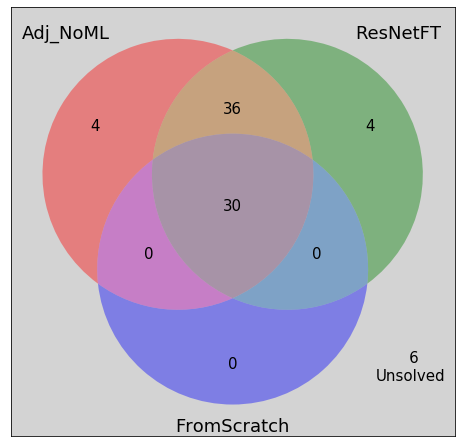

In [102]:
fig = plt.figure()
plt.rcParams.update({'font.size':15})
v = venn3_unweighted(subsets = (4, 4, 36, 0,0,0,30), set_labels=('Adj_NoML', 'ResNetFT', 'FromScratch'))
plt.axis("on")
plt.text(0.45, -0.55, '       6\nUnsolved')
plt.gca().set_facecolor('lightgray')
fig.tight_layout(pad=-5);

## Comments

The current evaluation classifies a puzzle as _unsolved_ even if the models got a major chunk right but placed it incorrectly on the board. So we will further visually investigate what the models did on puzzles they did not solve completey correctly. 